In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
### functions

sns.set(font_scale=1.1)

RANDOM_STATE = 12345

def evaluate_classifier(model, X_test, y_test, label_encoder=None):
    labels = list(model.classes_)
    pred = model.predict(X_test) 
    if type(model['clf']) == XGBClassifier:
        pred = label_encoder.inverse_transform(pred)
        labels = label_encoder.inverse_transform(labels)
    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [3]:
df_train = pd.read_csv('../../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)
df_train['tokenized'] = df_train['tokenized'].apply(literal_eval)

df_test = pd.read_csv('../../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)
df_test['tokenized'] = df_test['tokenized'].apply(literal_eval)

df_train.head()

,filename,artist,title,genre,lyrics,instrumental,tokenized,lemmatized
0,country.00041.wav,Johnny Cash,Goin' By The Book,country,\nYou can see it in the movies and the paper a...,False,"[see, movies, paper, tv, news, somebodys, army...","[see, movie, paper, tv, news, somebody, army, ..."
1,reggae.00038.wav,Burning Spear,Investigation Dub,reggae,I and I old I know\nI and I old I say\nI and I...,False,"[old, know, old, say, reconsider, see, upfully...","[old, know, old, say, reconsider, see, upfully..."
2,disco.00070.wav,KC and The Sunshine Band,That's The Way (I Like It),disco,"That's the way, aha, aha\nI like it, aha, aha\...",False,"[thats, way, aha, aha, like, aha, aha, thats, ...","[thats, way, aha, aha, like, aha, aha, thats, ..."
3,reggae.00088.wav,Marcia Griffiths,Electric Boogie,reggae,\nIt's electric!\n\n\nYou can't see it\nIt's e...,False,"[electric, cant, see, electric, got, ta, feel,...","[electric, cant, see, electric, get, ta, feel,..."
4,pop.00017.wav,Britney Spears,(I Can't Get No) Satisfaction,pop,\nI can't get no satisfaction\nI can't get no ...,False,"[cant, get, satisfaction, cant, get, satisfact...","[cant, get, satisfaction, cant, get, satisfact..."


In [4]:
# word vectors of the following dimensions are available: 50d, 100d, 200d, 300d 
GLOVE_MODELS = {}

for dim in ["100d", "300d"]:#["50d", "100d", "200d", "300d"]:
    glove_path = f"../../glove/glove.6B.{dim}.txt"
    glove_word2vec_path = glove_path + '.word2vec'

    if os.path.exists(glove_word2vec_path):
        # load the Stanford GloVe model
        print(f"Loading saved glove word2vec {dim} model")
        GLOVE_MODELS[dim] = KeyedVectors.load_word2vec_format(glove_word2vec_path, binary=False)
    else:
        # load the Stanford GloVe model from txt file, convert to word2vec and save
        print(f"Creating glove word2vec {dim} model")
        glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        glove_model.save_word2vec_format(glove_word2vec_path)
        GLOVE_MODELS[dim] = glove_model

print(GLOVE_MODELS)

Loading saved glove word2vec 100d model
Loading saved glove word2vec 300d model
{'100d': <gensim.models.keyedvectors.KeyedVectors object at 0x7f3bd9211280>, '300d': <gensim.models.keyedvectors.KeyedVectors object at 0x7f3c306b75b0>}


In [5]:
from sklearn.base import BaseEstimator

# create vectorizer that uses glove embeddings
class LyricsVectorizer(BaseEstimator):
    def __init__(self, word_vec_dim="100d", method="mean"):
        self.word_vectors = GLOVE_MODELS[word_vec_dim]
        self.word_vec_dim = word_vec_dim
        self.method = method

    def fit(self, X, y=None):
        return self

    def _transform(self, data):
        # determine the dimensionality of vectors
        vec = np.zeros(self.word_vectors.vector_size)
        
        if type(data) == list:
            #print("Data is tokenized")
            tokenized = True
        elif type(data) == str:
            #print("Data is non-tokenized string")
            tokenized = False
        else:
            print("Not recognized data type")
            return None
        
        if tokenized:
            tokens = data
        else:
            tokens = data.split()
        vecs = []
        for word in tokens:
            try:
                # throws KeyError if word not found
                word_embed = self.word_vectors.get_vector(word)
                vecs.append(word_embed)
            except KeyError:
                pass
        if len(vecs) > 0:
            vecs = np.array(vecs)
            if self.method == "mean":
                vec = vecs.mean(axis=0) # lyrics embedding = mean over all words
            else:
                vec = vecs.sum(axis=0) # lyrics embedding = sum over all words
            # maybe consider concatenation?
        return vec
    
    def transform(self, X):
        return np.concatenate(
            [self._transform(row).reshape(1, -1) for row in X]
            )
    
    def get_params(self, deep=True):
        result = {"word_vec_dim": self.word_vec_dim, "method": self.method}
        return result

## Classifier

In [6]:
# Create train and test matrices
X_train = df_train['lemmatized']
y_train = df_train['genre']

X_test = df_test['lemmatized']
y_test = df_test['genre']

# encode train labels for xgboost
label_enc = LabelEncoder()
label_enc = label_enc.fit(y_train)
y_train_enc = label_enc.transform(y_train)

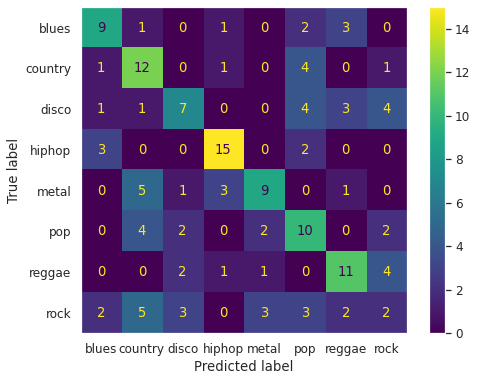

Accuracy  = 0.49019607843137253
F1 score  = 0.4799096572648998
Precision = 0.4816263257439728
Recall    = 0.49019607843137253


In [7]:
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d", method="mean")),
    ('norm', StandardScaler()),
    ('clf', SVC())
])

pipe.fit(X_train, y_train)

evaluate_classifier(pipe, X_test, y_test)

# Parameter GridSeach 

## Bayes

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV score = 0.389 with the following parameters:
{'clf__var_smoothing': 1e-11, 'vec__method': 'mean'}


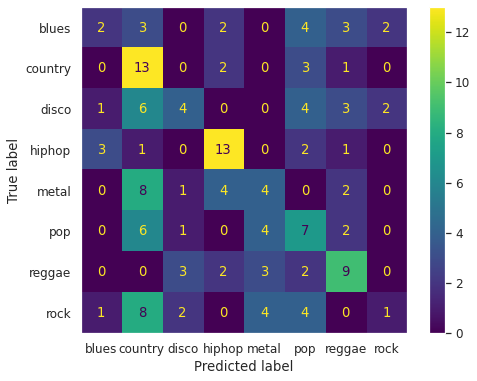

Accuracy  = 0.3464052287581699
F1 score  = 0.3167530524907191
Precision = 0.3348466127664763
Recall    = 0.3464052287581699


In [8]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('norm', StandardScaler()),
    ('clf', GaussianNB())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV score = 0.389 with the following parameters:
{'clf__var_smoothing': 1e-11, 'vec__method': 'mean'}


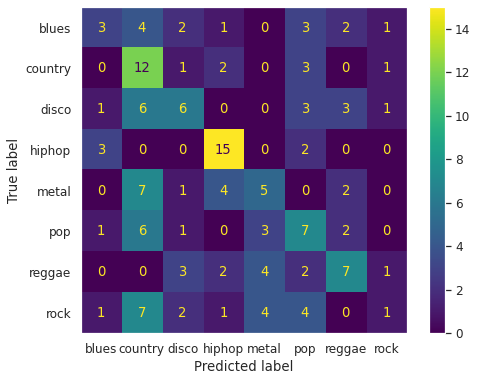

Accuracy  = 0.3660130718954248
F1 score  = 0.3418798537795645
Precision = 0.3551976346093993
Recall    = 0.3660130718954248


In [9]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('norm', StandardScaler()),
    ('clf', GaussianNB())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

## Random Forest Classifier

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.471 with the following parameters:
{'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'clf__random_state': 12345, 'vec__method': 'sum'}


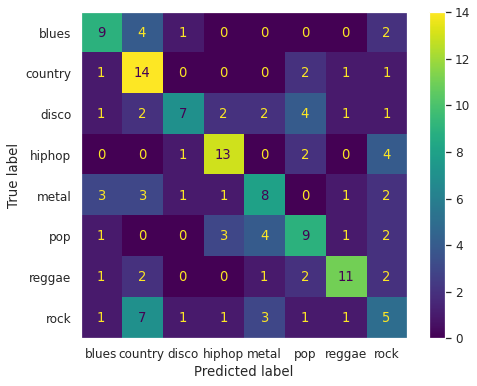

Accuracy  = 0.49673202614379086
F1 score  = 0.49332144985677745
Precision = 0.5116370150441054
Recall    = 0.49673202614379086


In [10]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('norm', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
    'vec__method':["mean", "sum"],
    'clf__n_estimators': [50, 100, 500, 1000],
    'clf__max_depth': [3, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__random_state': [RANDOM_STATE]
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.476 with the following parameters:
{'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 500, 'clf__random_state': 12345, 'vec__method': 'sum'}


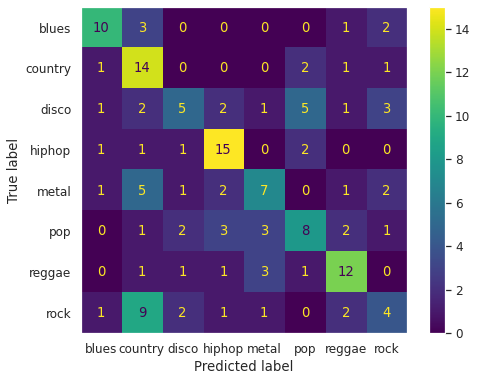

Accuracy  = 0.49019607843137253
F1 score  = 0.4749480139763948
Precision = 0.48495614770124584
Recall    = 0.49019607843137253


In [11]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('norm', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
    'vec__method':["mean", "sum"],
    'clf__n_estimators': [50, 100, 500, 1000],
    'clf__max_depth': [3, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__random_state': [RANDOM_STATE]
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

## SVM

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best CV score = 0.463 with the following parameters:
{'clf__C': 100, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'vec__method': 'sum'}


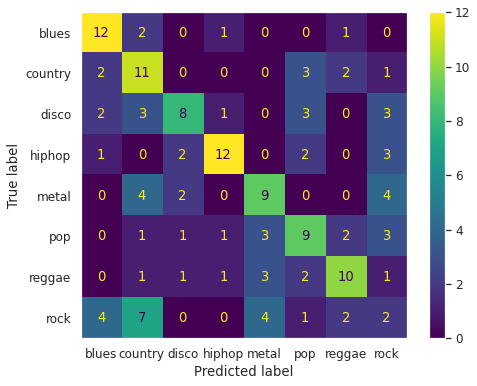

Accuracy  = 0.477124183006536
F1 score  = 0.4741799180957197
Precision = 0.4856714829271804
Recall    = 0.477124183006536


In [14]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('norm', StandardScaler()),
    ('clf', SVC())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'],
    'clf__gamma': ['auto', 'scale', 0.1, 0.001],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best CV score = 0.486 with the following parameters:
{'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'vec__method': 'sum'}


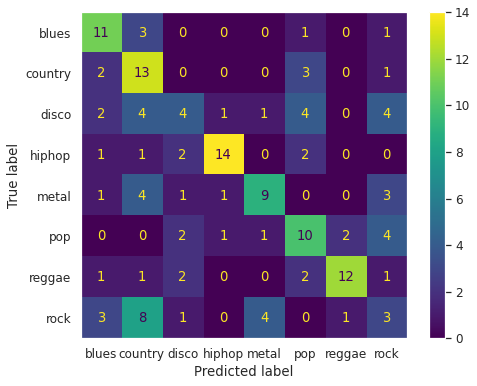

Accuracy  = 0.49673202614379086
F1 score  = 0.49154930959461873
Precision = 0.5098250589600071
Recall    = 0.49673202614379086


In [15]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('norm', StandardScaler()),
    ('clf', SVC())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'],
    'clf__gamma': ['auto', 'scale', 0.1, 0.001],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

## XGBoost

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.481 with the following parameters:
{'clf__learning_rate': 0.2, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'vec__method': 'sum'}


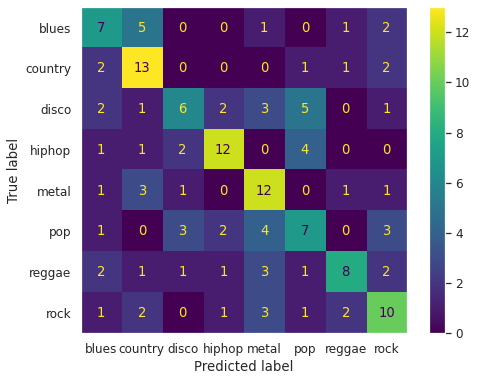

Accuracy  = 0.49019607843137253
F1 score  = 0.4852214435264601
Precision = 0.4967719404980378
Recall    = 0.49019607843137253


In [12]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('norm', StandardScaler()),
    ('clf', XGBClassifier())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__max_depth': [3, 6, 10],
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__learning_rate': [0.01, 0.1, 0.2],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train_enc)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test, label_enc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.460 with the following parameters:
{'clf__learning_rate': 0.2, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__method': 'mean'}


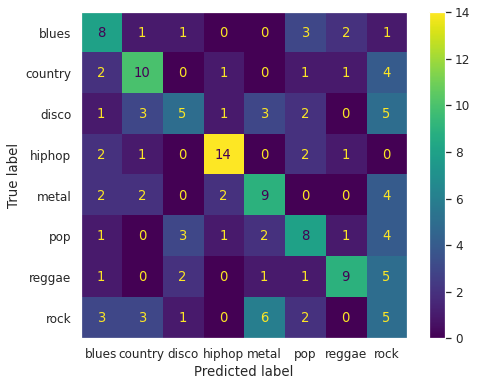

Accuracy  = 0.4444444444444444
F1 score  = 0.44934056502683956
Precision = 0.4661424803839665
Recall    = 0.4444444444444444


In [13]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('norm', StandardScaler()),
    ('clf', XGBClassifier())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__max_depth': [3, 6, 10],
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__learning_rate': [0.01, 0.1, 0.2],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train_enc)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test, label_enc)